In [1]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d

import time
import matplotlib.dates as md



%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import pandas as pd

import networkx as nx

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


# Import data

In [2]:
df_edges = pd.read_csv('../data/graph_edges_with_directionality.csv')

G = nx.DiGraph()
for orig,desti in zip(df_edges['origin_place_id'], df_edges['destination_place_id']):
    G.add_edge(orig, desti)
nodes = list(G.nodes())

In [3]:
train_data = np.load("../DCRNN/data/OUR/train.npz")
test_data = np.load("../DCRNN/data/OUR/test.npz")

In [4]:
train_data['x'].shape, train_data['y'].shape

((18262, 12, 270, 2), (18262, 12, 270, 2))

## use data of 0th node and set prev/future steps

In [5]:
node_data = train_data['x'][:,:,0,0]
test_node_data = test_data['x'][:,:,0,0]

In [6]:
cleaner_train = [max(np.append(tx,ty)) == ty[-1] for tx,ty in zip(train_data['x'][:,:,0,1], train_data['y'][:,:,0,1])]

In [7]:
cleaner_test = [max(np.append(tx,ty)) == ty[-1] for tx,ty in zip(test_data['x'][:,:,0,1],test_data['y'][:,:,0,1])]

In [8]:
cats = [cat for cat in train_data]

In [9]:
cleaned_train_data = dict()
cleaned_test_data = dict()
for cat in cats[:2]:
    cleaned_train_data[cat] = train_data[cat][cleaner_train]
    cleaned_test_data[cat] = test_data[cat][cleaner_test]

In [10]:
prev_steps = 12
future_steps = 12
# number of mini 
nodes = [0,13, 20, 30]

# define data loader functions

# Build Network

In [11]:
from torch.nn import LSTM, Dropout
num_prev_steps = prev_steps
num_l1 = num_prev_steps
num_l2 = num_prev_steps
num_pred_steps = future_steps
hidden_size=30
class Net(nn.Module):
    def __init__(self, num_prev_steps, num_pred_steps, num_l1, num_nodes):   
        super(Net, self).__init__()
        self.num_prev_steps=num_prev_steps
        self.num_pred_steps=num_pred_steps
        self.lstm=torch.nn.LSTM(input_size=num_nodes,hidden_size=hidden_size)
        self.dp1=Dropout(0.5)
        self.l1=Linear(num_prev_steps,num_pred_steps)
        self.l2=Linear(hidden_size,num_nodes)
        
        
    def forward(self, x):
        #input (batch_size, previous steps, number of nodes)
        #output (batch_size, future steps, number of nodes)
        x=x.permute(1,0,2)#(seq,bat,nod)
        x,_=self.lstm(x)
        x=self.dp1(x)
        x=x.permute(1,2,0)#(bat,nod,seq)
        x=sigmoid(self.l1(x))
        #x=self.dp1(x)
        x=x.permute(0,2,1)
        x=sigmoid(self.l2(x))
        return x
net = Net(num_prev_steps, num_pred_steps, num_l1, len(nodes))
print(net)

Net(
  (lstm): LSTM(4, 30)
  (dp1): Dropout(p=0.5)
  (l1): Linear(in_features=12, out_features=12, bias=True)
  (l2): Linear(in_features=30, out_features=4, bias=True)
)


# define criterion and optimizer

In [12]:
import torch.optim as optim

lr = 0.005
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

## Test for 1 training step

In [13]:
batch_size = 20
x_batch = Variable(torch.from_numpy(cleaned_train_data['x'][:batch_size,-prev_steps:,nodes,0])).float()
print(x_batch.shape)
output = net(x_batch)
target = Variable(torch.from_numpy(cleaned_train_data['y'][:batch_size,:future_steps,nodes,0]).float()).view(-1, num_pred_steps, len(nodes))
print(output.shape)
print(target.shape)
batch_loss = criterion(output, target)
print("Sucess")

torch.Size([20, 12, 4])
torch.Size([20, 12, 4])
torch.Size([20, 12, 4])
Sucess


/home/hurt0jan/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Training loop

epoch is 49
cur_loss is tensor(0.0000, grad_fn=<DivBackward0>)
test loss is tensor(1.6506e-07, grad_fn=<DivBackward0>)


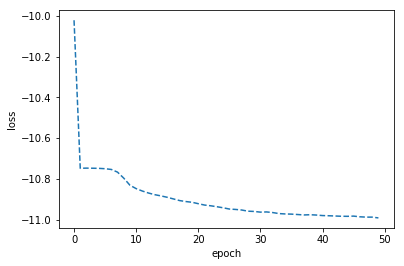

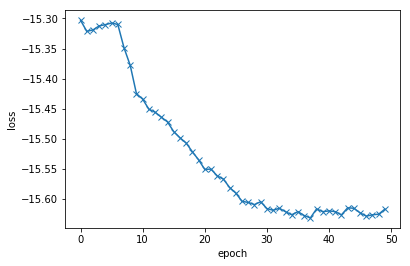

In [14]:
num_epoch = 50
batch_size = 50
clip = 100

losses = []
test_losses = []
k = 0

for ep_ind in range(num_epoch):
    cur_losses = []
    net.train()
    
    #go from 0 to epoch_size in batch_size steps
    #to get completely new data for every batch
    
    for i in range(0, len(cleaned_train_data['x']), batch_size):
        #print(get_batch(i, batch_size))
        np_batch = cleaned_train_data['x'][i:i+batch_size,-prev_steps:,nodes,0]
        x_batch = Variable(torch.from_numpy(np_batch)).float()
        output = net(x_batch)
        target_batch = Variable(torch.from_numpy(cleaned_train_data['y'][i:i+batch_size,:future_steps,nodes,0]).float()).view(-1, num_pred_steps, len(nodes))
        batch_loss = criterion(output, target_batch)

        
        #x_batch = Variable(torch.from_numpy(np_batch[0])).float()
        #output = net(x_batch)
        #target_batch = Variable(torch.from_numpy(np_batch[1]).float())
        #batch_loss = criterion(output[0], target_batch)
        #if k < 100:
        #    print(batch_loss)
        #    k = k + 1

        optimizer.zero_grad()
        batch_loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
        
        cur_losses.append(batch_loss/len(np_batch))
    
    net.eval()
    test_pred = net(torch.from_numpy(cleaned_test_data['x'][:,-prev_steps:,nodes,0]).float())
    test_target = torch.from_numpy(cleaned_test_data['y'][:,:future_steps,nodes,0]).float().view(-1, num_pred_steps, len(nodes))
    test_losses.append(criterion(test_pred, test_target)/len(test_target))
    
    losses.append(sum(cur_losses)/len(cur_losses))
    print("epoch is " + str(ep_ind))
    print("cur_loss is " + str(losses[-1]) )
    print("test loss is " + str(test_losses[-1]))
    plt.plot(np.log(losses), linestyle = '--')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    plt.plot(np.log(test_losses), marker = 'x')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    clear_output(wait=True)

In [16]:
test_pred = net(torch.from_numpy(cleaned_test_data['x'][:,-prev_steps:,nodes,0]).float())[:,:,1]
test_target = torch.from_numpy(cleaned_test_data['y'][:,:future_steps,nodes,0]).float().view(-1, num_pred_steps, len(nodes))[:,:,1]

criterion(test_pred, test_target).detach().numpy()/len(test_pred)

2.1020329617334546e-07

In [20]:
torch.save(test_pred,'LSTMpred.pt')